## PyTorch | Logistic Regression with Sklearn Make-Circles Dataset   { BINARY CLASSIFICATION }
This notebook demonstrates how to implement logistic regression using PyTorch, specifically focusing on the make_circles dataset. We will explore the importance of non-linear activation functions for classification tasks with non-linear data.

### Objective:
Our primary goal is to build a PyTorch model that can effectively classify data points from the make_circles dataset. We'll compare a simple linear model with a model incorporating non-linear activation functions to highlight their necessity for non-linearly separable data. The final output will include training/testing metrics and visualizations of the decision boundaries.

### About the Data:
We will use the make_circles dataset from sklearn.datasets. This utility function generates a synthetic 2D dataset composed of two concentric circles. It's a classic example used to illustrate scenarios where linear classification models fail, and non-linear models are required.

### Key characteristics of the make_circles dataset:
- **Structure:** It creates data points forming a larger outer circle and a smaller, inner circle, both centered at the same point.

- **Dimensionality:** Each data point is represented in 2D space, meaning it has two features (X1 and X2, corresponding to x and y coordinates).

- **Purpose:** It's ideal for demonstrating machine learning algorithms that can handle non-linear decision boundaries. A straight line cannot perfectly separate the inner circle from the outer circle.

- **Features and Labels:**

    - We get 2 features (X1 and X2): These are the (x, y) coordinates of each data point.

    - We get 1 label (y): This indicates which circle a data point belongs to (e.g., 0 for the inner circle, 1 for the outer circle).

## 1. Data Preparation
### .1. Generate the Dataset
We use make_circles to create our synthetic dataset. n_samples determines the number of data points, noise adds a bit of randomness to make the circles less perfect (simulating real-world data imperfections), and random_state ensures reproducibility.

In [51]:
from sklearn.datasets import make_circles
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import numpy as np 

n_samples = 1000 
noise = 0.03     
random_state = 42 

# Generate features (X) and labels (y)
X, y = make_circles(n_samples, noise=noise, random_state=random_state)

### 1.2. Inspect the Data
Let's look at the first few samples of our generated features (X) and labels (y) to understand their structure.

In [52]:
print(f"First 5 feature vectors (X):\n{X[:5]}")
print(f"First 5 labels (y):\n{y[:5]}")

First 5 feature vectors (X):
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels (y):
[1 1 1 1 0]


### 1.3. Convert to DataFrame (for easier inspection)
Converting the NumPy arrays to a Pandas DataFrame helps in visualizing and understanding the data structure, especially with named columns.

In [53]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
print("First 5 rows of the DataFrame:")
circles.head(5)


First 5 rows of the DataFrame:


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### 1.4. Check Label Distribution
It's good practice to check the distribution of our labels to ensure the dataset is balanced (i.e., roughly equal numbers of samples for each class).

In [54]:
print("Label distribution:")
circles.label.value_counts()

Label distribution:


label
1    500
0    500
Name: count, dtype: int64

### 1.5. Visualize the Dataset
Plotting the data points helps us understand the non-linear separability of the make_circles dataset. We'll use different colors for different labels.

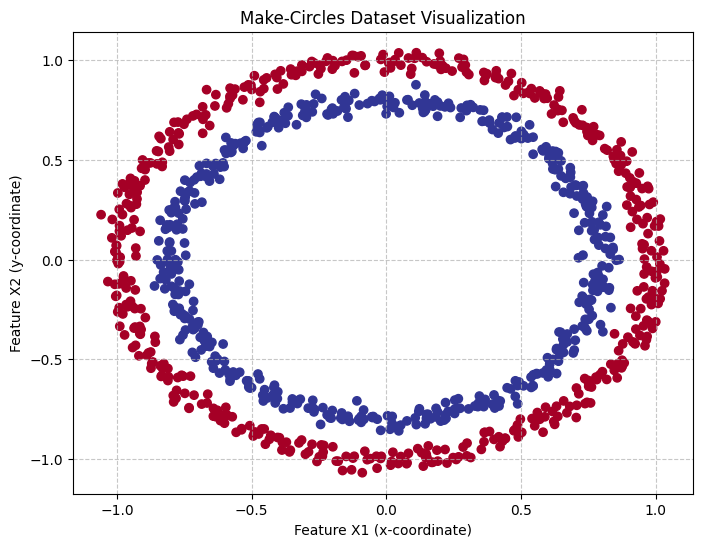

In [55]:
plt.figure(figsize=(8, 6)) 
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu) 
plt.title("Make-Circles Dataset Visualization")
plt.xlabel("Feature X1 (x-coordinate)")
plt.ylabel("Feature X2 (y-coordinate)")
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

### 1.6. Check Dataset Shape
Understanding the shape of our feature (X) and label (y) arrays is crucial for defining the input and output dimensions of our PyTorch models.

In [56]:
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


Shape of X (features): (1000, 2)
Shape of y (labels): (1000,)


### 1.7. Convert to PyTorch Tensors
PyTorch models operate exclusively on torch.Tensor objects. We convert our NumPy arrays to tensors and ensure they have the correct data type (torch.float). For labels in binary classification, torch.float is typically used with BCEWithLogitsLoss.

In [57]:
# Convert NumPy arrays to PyTorch tensors
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float) 

# Display the first 5 converted tensors to confirm
print(f"First 5 X tensors:\n{X[:5]}")
print(f"First 5 y tensors:\n{y[:5]}")

First 5 X tensors:
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First 5 y tensors:
tensor([1., 1., 1., 1., 0.])


### 1.8. Split Data into Training and Testing Sets
It's standard practice in machine learning to split data into training and testing sets. The model learns from the training data and its performance is evaluated on unseen test data to ensure it generalizes well.

In [58]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Display the number of samples in each set
print(f"Number of samples in X_train: {len(X_train)}")
print(f"Number of samples in X_test: {len(X_test)}")
print(f"Number of samples in y_train: {len(y_train)}")
print(f"Number of samples in y_test: {len(y_test)}")


Number of samples in X_train: 800
Number of samples in X_test: 200
Number of samples in y_train: 800
Number of samples in y_test: 200


### 1.9. Device Agnostic Code Setup (Optional but Recommended)
For optimal performance, especially with larger datasets and models, it's beneficial to utilize a GPU (CUDA) if available. This step sets up a device variable that can be either "cuda" (GPU) or "cpu", making your code device-agnostic.

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 2. Model Definition
We will define two different neural network models: one purely linear and one that incorporates non-linear activation functions. This will demonstrate why non-linearity is crucial for this dataset.

### 2.1. Linear Model Class (CicleModelV0)
This model consists solely of stacked linear layers. Without any non-linear activation functions between them, it can only learn linear decision boundaries.

In [60]:
class CicleModelV0(nn.Module):
    """
    A simple linear model for binary classification.
    It consists of three stacked linear layers without any non-linear activation functions.
    This model is expected to perform poorly on non-linearly separable data like make_circles.
    """
    def __init__(self):
        super().__init__()
        self.layer_0 = nn.Linear(in_features=2, out_features=5)
        self.layer_1 = nn.Linear(in_features=5, out_features=3)
        self.layer_2 = nn.Linear(in_features=3, out_features=1)
    
    def forward(self, x):
        z = self.layer_0(x)
        z = self.layer_1(z)
        z = self.layer_2(z)
        return z 

### Instantiate the Linear Model
Create an instance of CicleModelV0 and move it to the selected device (CPU or GPU).

In [61]:
model_0 = CicleModelV0()
model_0.to(device) 
print("Linear Model (CicleModelV0):")
print(model_0)


Linear Model (CicleModelV0):
CicleModelV0(
  (layer_0): Linear(in_features=2, out_features=5, bias=True)
  (layer_1): Linear(in_features=5, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=1, bias=True)
)


### 2.2. Non-Linear Model Class (CicleModelV1)
This model introduces nn.ReLU() (Rectified Linear Unit) activation functions between the linear layers. ReLU adds non-linearity, allowing the model to learn complex, non-linear patterns in the data.

In [62]:
class CicleModelV1(nn.Module):
    """
    A non-linear model for binary classification, incorporating ReLU activation functions.
    ReLU introduces non-linearity, enabling the model to learn complex decision boundaries
    required for datasets like make_circles.
    """
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10), 
            nn.ReLU(),                                 
            nn.Linear(in_features=10, out_features=10), 
            nn.ReLU(),                                
            nn.Linear(in_features=10, out_features=1)  
        )
    
    def forward(self, x):
        return self.layer_stack(x) 


### Instantiate the Non-Linear Model
Create an instance of CicleModelV1 and move it to the selected device.

In [63]:
model_1 = CicleModelV1()
model_1.to(device) 
print("Non-Linear Model (CicleModelV1):")
print(model_1)


Non-Linear Model (CicleModelV1):
CicleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


## 3. Loss Function and Optimizer
For binary classification with logits (raw outputs from the model before activation), nn.BCEWithLogitsLoss() is a robust choice. torch.optim.SGD (Stochastic Gradient Descent) will be used to update model parameters.


In [64]:
# BCEWithLogitsLoss combines Sigmoid and Binary Cross Entropy Loss for numerical stability.

loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer (Stochastic Gradient Descent)
# It will update the model's parameters (weights and biases) to minimize the loss.
learning_rate = 0.1
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate) 
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=learning_rate) 


## 4. Accuracy Function
A helper function to calculate the accuracy of our model's predictions. Accuracy is the percentage of correctly classified samples.

In [65]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates the accuracy of predictions.
    Compares predicted labels with true labels and returns the percentage of correct matches.
    """
    y_true = y_true.to(y_pred.device)
    correct = torch.eq(y_true, y_pred).sum().item() 

    acc = (correct / len(y_pred)) * 100
    return acc


## 5. Training and Testing Loops
We will build training and testing loops for both our linear (model_0) and non-linear (model_1) models to compare their performance.

### 5.1. Training and Testing Loop for Linear Model (CicleModelV0)
This loop trains model_0 for a specified number of epochs, calculating and printing training and testing loss and accuracy periodically.

In [66]:

torch.manual_seed(42)

epochs = 1000 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print("--- Training Linear Model (CicleModelV0) ---")
for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()                      
    y_pred = torch.round(torch.sigmoid(y_logits))              

    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer_0.zero_grad()
    
    loss.backward()

    optimizer_0.step()

    model_0.eval()
    with torch.inference_mode(): 
        test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

model_0.eval()
with torch.inference_mode():
    y_pred_linear = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
    final_test_loss_linear = loss_fn(model_0(X_test).squeeze(), y_test).item()
    final_test_acc_linear = accuracy_fn(y_true=y_test, y_pred=y_pred_linear)
    print(f"\n--- Final Linear Model Performance ---")
    print(f"Final Test Loss (Linear): {final_test_loss_linear:.4f}")
    print(f"Final Test Accuracy (Linear): {final_test_acc_linear:.2f}%")


--- Training Linear Model (CicleModelV0) ---
Epoch: 0 | Train Loss: 0.7004, Train Acc: 50.00% | Test Loss: 0.6986, Test Acc: 50.00%


Epoch: 100 | Train Loss: 0.6936, Train Acc: 50.62% | Test Loss: 0.6925, Test Acc: 51.50%
Epoch: 200 | Train Loss: 0.6934, Train Acc: 50.62% | Test Loss: 0.6927, Test Acc: 50.50%
Epoch: 300 | Train Loss: 0.6933, Train Acc: 50.25% | Test Loss: 0.6929, Test Acc: 50.00%
Epoch: 400 | Train Loss: 0.6932, Train Acc: 50.25% | Test Loss: 0.6930, Test Acc: 50.50%
Epoch: 500 | Train Loss: 0.6932, Train Acc: 50.25% | Test Loss: 0.6932, Test Acc: 53.50%
Epoch: 600 | Train Loss: 0.6931, Train Acc: 51.50% | Test Loss: 0.6933, Test Acc: 49.50%
Epoch: 700 | Train Loss: 0.6931, Train Acc: 50.88% | Test Loss: 0.6934, Test Acc: 50.00%
Epoch: 800 | Train Loss: 0.6931, Train Acc: 51.25% | Test Loss: 0.6935, Test Acc: 49.00%
Epoch: 900 | Train Loss: 0.6931, Train Acc: 51.12% | Test Loss: 0.6937, Test Acc: 48.00%

--- Final Linear Model Performance ---
Final Test Loss (Linear): 0.6938
Final Test Accuracy (Linear): 47.00%


### 5.2. Training and Testing Loop for Non-Linear Model (CicleModelV1)
This loop trains model_1, which includes ReLU activations. We expect this model to perform significantly better on the make_circles dataset due to its ability to learn non-linear decision boundaries.

In [67]:
torch.manual_seed(42)

epochs = 1000 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print("\n--- Training Non-Linear Model (CicleModelV1) ---")
for epoch in range(epochs):

    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer_1.zero_grad()
    
    loss.backward()

    optimizer_1.step()

    model_1.eval()
    with torch.inference_mode():

        test_logits = model_1(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

model_1.eval()
with torch.inference_mode():
    y_pred_nonlinear = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
    final_test_loss_nonlinear = loss_fn(model_1(X_test).squeeze(), y_test).item()
    final_test_acc_nonlinear = accuracy_fn(y_true=y_test, y_pred=y_pred_nonlinear)
    print(f"\n--- Final Non-Linear Model Performance ---")
    print(f"Final Test Loss (Non-Linear): {final_test_loss_nonlinear:.4f}")
    print(f"Final Test Accuracy (Non-Linear): {final_test_acc_nonlinear:.2f}%")



--- Training Non-Linear Model (CicleModelV1) ---
Epoch: 0 | Train Loss: 0.6938, Train Acc: 50.00% | Test Loss: 0.6949, Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.6914, Train Acc: 54.37% | Test Loss: 0.6928, Test Acc: 50.50%
Epoch: 200 | Train Loss: 0.6893, Train Acc: 55.75% | Test Loss: 0.6917, Test Acc: 55.00%
Epoch: 300 | Train Loss: 0.6863, Train Acc: 55.25% | Test Loss: 0.6898, Test Acc: 53.00%
Epoch: 400 | Train Loss: 0.6816, Train Acc: 56.50% | Test Loss: 0.6867, Test Acc: 55.00%
Epoch: 500 | Train Loss: 0.6752, Train Acc: 58.25% | Test Loss: 0.6817, Test Acc: 56.50%
Epoch: 600 | Train Loss: 0.6651, Train Acc: 61.00% | Test Loss: 0.6731, Test Acc: 59.00%
Epoch: 700 | Train Loss: 0.6464, Train Acc: 66.62% | Test Loss: 0.6558, Test Acc: 67.00%
Epoch: 800 | Train Loss: 0.6116, Train Acc: 82.12% | Test Loss: 0.6238, Test Acc: 79.50%
Epoch: 900 | Train Loss: 0.5406, Train Acc: 93.62% | Test Loss: 0.5597, Test Acc: 91.50%

--- Final Non-Linear Model Performance ---
Final Test Loss (N


## 6. Visualization of Decision Boundaries
To truly understand how well our models perform, we can visualize their decision boundaries. This shows the regions where the model predicts one class versus another.

### 6.1. Download Helper Functions
We'll download a helper_functions.py script from a public GitHub repository. This script contains utility functions for plotting, including plot_decision_boundary.

In [68]:
import requests
from pathlib import Path 

helper_functions_path = Path("helper_functions.py")

if helper_functions_path.is_file():
  print(f"{helper_functions_path} already exists, skipping download.")
else:
  print(f"Downloading {helper_functions_path}...")
  request_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
  try:
      request = requests.get(request_url)
      request.raise_for_status() 
      with open(helper_functions_path, "wb") as f:
        f.write(request.content)
      print(f"{helper_functions_path} downloaded successfully.")
  except requests.exceptions.RequestException as e:
      print(f"Error downloading helper_functions.py: {e}")
      print("Please ensure you have an internet connection or download it manually from:")
      print(request_url)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download.


### 6.2. Plot Decision Boundaries for Both Models
We will plot the decision boundaries for both model_0 (linear) and model_1 (non-linear) on the test dataset. This visualization will clearly show the impact of adding non-linearity.

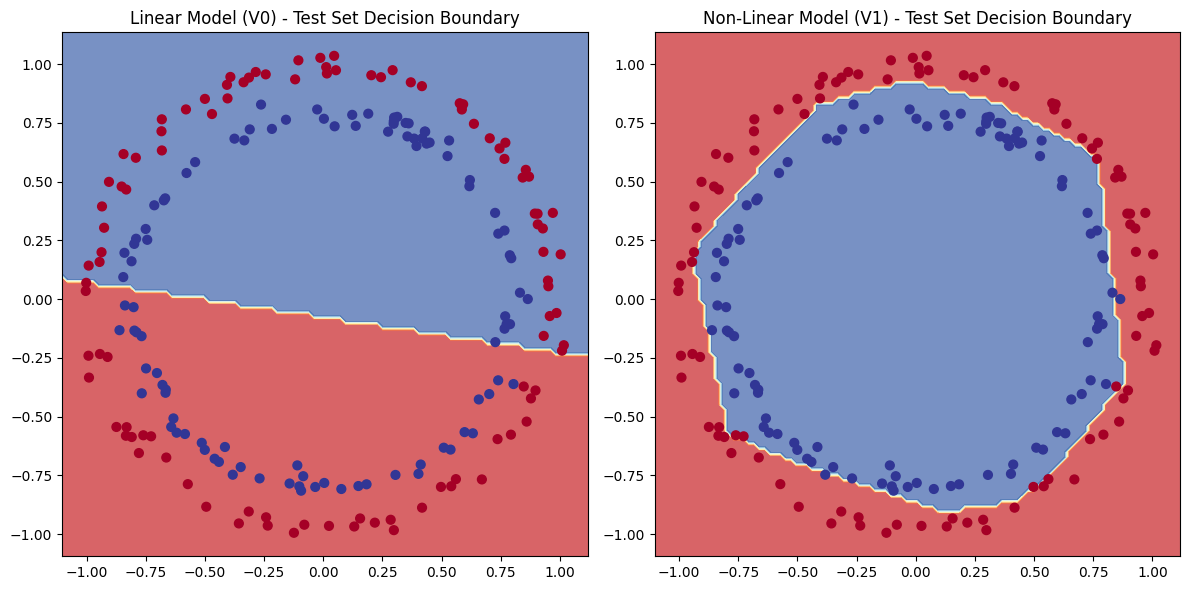

CicleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [69]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
plt.title("Linear Model (V0) - Test Set Decision Boundary")
plot_decision_boundary(model_0.to("cpu"), X_test.to("cpu"), y_test.to("cpu"))

plt.subplot(1, 2, 2) 
plt.title("Non-Linear Model (V1) - Test Set Decision Boundary")
plot_decision_boundary(model_1.to("cpu"), X_test.to("cpu"), y_test.to("cpu"))

plt.tight_layout() 
plt.show()

model_0.to(device)
model_1.to(device)

## 7. Conclusion
- By comparing the performance metrics and decision boundary plots of CicleModelV0 (linear) and CicleModelV1 (non-linear), we can clearly observe:

- The linear model (V0) struggles with the make_circles dataset, achieving an accuracy around 50% (equivalent to random guessing). Its decision boundary is a straight line, which cannot separate concentric circles.

- The non-linear model (V1), thanks to the ReLU activation functions, is able to learn a complex, curved decision boundary, resulting in significantly higher accuracy (close to 100%).

This demonstrates the fundamental importance of incorporating non-linearity into neural networks when dealing with data that is not linearly separable.